## Flowers Recognition

In this notebook we solve classification task using DL. data set also available on TensorFlow Datasets: https://www.tensorflow.org/datasets/catalog/oxford_flowers102

## Context:
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set. The training set and validation set each consist of 10 images per class (totalling 1030 images each). The test set consist of the remaining 6129 images (minimum 20 per class).

## Goal:
To build a inverse image search model.

## 1. Importing the data
Data:

1.1. Preparing environment and importing libraries

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
SETUP = True

In [4]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q  --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

0.1.30
2.0.0


In [0]:
# %load_ext nb_black

In [0]:
import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [7]:
from toai.imports import *
from toai.data import Dataset, DataParams, DataContainer
from toai.image import ImageLearner, ImageAugmentor, ImageDataset, ImageResizer
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:68: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [0]:
from typing import *

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Data preparation and preprocessing



In [0]:
DATA_DIR = Path("drive/My Drive/Kiti/AI/Projects/flowers10_8")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR = Path('drive/My Drive/Kiti/AI/Projects/temp/flowers10_8')
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 1024

In [0]:
IMG_DIMS = (99, 99, 3)

In [0]:
@attr.s(auto_attribs=True)
class ImageResizer:
    img_dims: Tuple[int, int, int]
    resize: Optional[str] = None
    crop_adjustment: float = 1

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        height, width, _ = self.img_dims
        if self.resize == "stretch":
            image = tf.image.resize(image, (height, width))
        elif self.resize == "crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(
                images=image, size=(crop_height, crop_width), preserve_aspect_ratio=True
            )
            image = tf.image.resize_with_crop_or_pad(image, height, width)
        elif self.resize == "random_crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(image, (crop_height, crop_width))
            image = tf.image.random_crop(image, self.img_dims)

        return image, label

In [0]:
@attr.s(auto_attribs=True)
class ImageScaler:
    scale_fn: Callable

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        return self.scale_fn(image), label

In [0]:
@tf.function
def preprocess_input(x):
    return x / 255.0

In [15]:
[
    repr(fn(np.array([[0, 127.5, 255], [0, 127.5, 255], [0, 127.5, 255]])))
    for fn in (
        keras.applications.xception.preprocess_input,
        keras.applications.inception_v3.preprocess_input,
        keras.applications.resnet_v2.preprocess_input,
        keras.applications.resnet50.preprocess_input,
        keras.applications.resnet.preprocess_input,
    )
]

['array([[-1.,  0.,  1.],\n       [-1.,  0.,  1.],\n       [-1.,  0.,  1.]])',
 'array([[-1.,  0.,  1.],\n       [-1.,  0.,  1.],\n       [-1.,  0.,  1.]])',
 'array([[-1.,  0.,  1.],\n       [-1.,  0.,  1.],\n       [-1.,  0.,  1.]])',
 'array([[ 151.061,   10.721, -123.68 ],\n       [ 151.061,   10.721, -123.68 ],\n       [ 151.061,   10.721, -123.68 ]])',
 'array([[ 151.061,   10.721, -123.68 ],\n       [ 151.061,   10.721, -123.68 ],\n       [ 151.061,   10.721, -123.68 ]])']

In [0]:
train_data, train_data_info = tfds.load(
    name="oxford_flowers102:2.*.*",
    split="train",# we oculd filter here the smaller amount of samples to run the model faster
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
)

In [0]:
# train_data = train_data.filter(lambda a, b: b < 3) the way to choose only 4 out of 102 classes to test fast if everything works

In [18]:
for x in train_data.take(1):
    print(x)

(<tf.Tensor: id=161, shape=(500, 667, 3), dtype=uint8, numpy=
array([[[1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 7, 2],
        [6, 7, 2],
        [5, 6, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 7, 2],
        [6, 7, 2],
        [5, 6, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 7, 2],
        [6, 7, 2],
        [5, 6, 1]]], dtype=uint8)>, <tf.Tensor: id=162, shape=(), dtype=int64, numpy=72>)


its not hte same sizes
its not squared
its not batched

In [0]:
train_data_size = len([x for x, _ in train_data])

In [20]:
train_data_size

1020

In [0]:
train_data_steps = math.ceil(train_data_size / BATCH_SIZE)

In [22]:
train_data_steps

32

In [0]:
n_classes = 102

In [0]:
train_data = (
    train_data.map(map_func=ImageResizer(img_dims=IMG_DIMS, resize="stretch"))
    .map(map_func=ImageScaler(keras.applications.xception.preprocess_input))
    #     .map(map_func=ImageScaler(preprocess_input))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

grey will be 0
the total blackness -1
total brightness 1

In [25]:
for x, y in train_data.take(1):
    print(x.numpy().min(), x.numpy().max(), x.numpy().mean())
    print(y)

-1.0 1.0 -0.21430282
tf.Tensor(
[29 45 27 70 16 40 54 35 31 67 70 22 81 25 84  5 69 13 18 14 69 13 93 91
 88 88 43 64 43 28 56 91], shape=(32,), dtype=int64)


to check what results we got

In [0]:
validation_data, validation_data_info = tfds.load(
    name="oxford_flowers102:2.*.*",
    split="validation",
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
)

In [0]:
# validation_data = validation_data.filter(lambda a, b: b < 3)

In [28]:
validation_data.take(1)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [0]:
validation_data_size = len([x for x, _ in validation_data])

In [0]:
validation_data_steps = math.ceil(validation_data_size / BATCH_SIZE)

In [0]:
validation_data = (
    validation_data.map(map_func=ImageResizer(img_dims=IMG_DIMS, resize="stretch"))
    .map(map_func=ImageScaler(keras.applications.xception.preprocess_input))
    #     .map(map_func=ImageScaler(preprocess_input))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
test_data, test_data_info = tfds.load(
    name="oxford_flowers102:2.*.*",
    split="test",
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
)

In [0]:
# test_data = test_data.filter(lambda a, b: b < 3)

In [0]:
test_data_size = len([x for x, _ in test_data])

In [0]:
test_data_steps = math.ceil(test_data_size / BATCH_SIZE)

In [0]:
test_data = (
    test_data.map(map_func=ImageResizer(img_dims=IMG_DIMS, resize="stretch"))
    .map(map_func=ImageScaler(keras.applications.xception.preprocess_input))
    #     .map(map_func=ImageScaler(preprocess_input))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

##3. Building a model

In [0]:
learner = ImageLearner(
    path=TEMP_DIR / "xception_v8",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[],
    override=True,
)

In [87]:
learner.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

is important to see what are the final layers

In [0]:
learner.squeeze_layer = keras.layers.Dense(
    16,
    activation=keras.activations.relu,
    kernel_initializer=keras.initializers.he_uniform(),
)
learner.output_layer = keras.layers.Dense(
    n_classes, activation=keras.activations.softmax
)

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=learner.output_layer(learner.squeeze_layer(learner.dropout_layer)),
)

In [90]:
learner.model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

65552 is the 4096 multiply 16

In [0]:
learner.compile(optimizer=tf.keras.optimizers.Adam, lr=1e-4)

In [92]:
train_data.take(1)

<TakeDataset shapes: ((None, 99, 99, 3), (None,)), types: (tf.float32, tf.int64)>

In [93]:
validation_data.take(1)

<TakeDataset shapes: ((None, 99, 99, 3), (None,)), types: (tf.float32, tf.int64)>

##4. Trainning the Model

In [94]:
history = learner.model.fit(
    x=train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data_steps,
    validation_steps=validation_data_steps,
    epochs=10,
)

Train for 32 steps, validate for 32 steps
Epoch 1/10
32/32 [==============================] - 22s 700ms/step - loss: 4.5536 - val_loss: 4.5985
Epoch 2/10
32/32 [==============================] - 11s 351ms/step - loss: 4.2031 - val_loss: 4.5347
Epoch 3/10
32/32 [==============================] - 11s 351ms/step - loss: 3.7140 - val_loss: 4.4235
Epoch 4/10
32/32 [==============================] - 11s 351ms/step - loss: 3.2340 - val_loss: 4.2837
Epoch 5/10
32/32 [==============================] - 11s 348ms/step - loss: 2.8902 - val_loss: 4.1590
Epoch 6/10
32/32 [==============================] - 11s 351ms/step - loss: 2.4321 - val_loss: 4.0754
Epoch 7/10
32/32 [==============================] - 11s 351ms/step - loss: 2.0376 - val_loss: 3.9923
Epoch 8/10
32/32 [==============================] - 11s 350ms/step - loss: 1.7117 - val_loss: 3.9243
Epoch 9/10
32/32 [==============================] - 11s 351ms/step - loss: 1.4669 - val_loss: 3.8569
Epoch 10/10
32/32 [==============================

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=learner.squeeze_layer(learner.dropout_layer), # deleted the last layer of 102 parameters
)

In [96]:
learner.model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

##5. Building an inverse image search using embeddings from pretrained image model

In [0]:
def show_distances(
    xs, ys, target_index, similar_indices, distances, cols: int = 4, debug: bool = False
):
    if cols >= len(distances) + 1:
        cols = len(distances) + 1
        rows = 1
    else:
        rows = math.ceil((len(distances) + 1) / cols)

    figsize = (3 * cols, 4 * rows) if debug else (3 * cols, 3 * rows)
    _, ax = plt.subplots(rows, cols, figsize=figsize)

    i = 0
    for x, y, distance in zip(
        xs[[target_index] + similar_indices],
        ys[[target_index] + similar_indices],
        [0] + distances,
    ):
        idx = (i // cols, i % cols) if rows > 1 else i % cols
        ax[idx].axis("off")
        ax[idx].imshow(x)
        title = f"Label: {y}\nShape: {x.shape}\n" if debug else f"{y}\n{distance:.2f}"
        ax[idx].set_title(title)
        i += 1

In [0]:
def dataset_to_array(dataset, steps):
    xs = []
    ys = []
    for x_batch, y_batch in dataset.take(steps):
        xs.append(x_batch.numpy())
        ys.append(y_batch.numpy())

    return np.asarray(xs).reshape((-1, *IMG_DIMS)), np.asarray(ys).flatten()

In [0]:
def inverse_preprocess_input(x):
    return (x + 1) / 2

we need that as we have from -1 to 1, in order to print, as it deals from 0 to 255

In [0]:
learner.compile(optimizer=tf.keras.optimizers.Adam, lr=1e-4)

In [0]:
xs, ys = dataset_to_array(validation_data, validation_data_steps)

In [102]:
xs.shape, ys.shape

((1024, 99, 99, 3), (1024,))

384 images and 384 labels

In [0]:
image_embeddings = learner.model.predict(xs)

In [104]:
image_embeddings.shape

(1024, 16)

In [0]:
nbrs = sk.neighbors.NearestNeighbors(n_neighbors=32, algorithm="ball_tree").fit(
    image_embeddings
)

19 because with 11 we didnt make any mistakes and we want to have more predictions

In [106]:
new_image_index = np.random.randint(len(ys))
new_image_index

796

In [0]:
new_prepared_image = xs[new_image_index : new_image_index + 1]

In [0]:
new_image_embeddings = learner.model.predict(new_prepared_image)

In [109]:
new_image_embeddings.shape

(1, 16)

In [0]:
distances, indices = nbrs.kneighbors(new_image_embeddings)

In [111]:
distances[0].tolist(), indices[0].tolist()

([4.775816350939305e-06,
  5.105814237274428,
  5.375948238358754,
  6.079904093054238,
  6.548659063145554,
  7.044845624810036,
  7.117610951218408,
  7.17036646345655,
  7.271375949793129,
  7.315114043076802,
  7.335151078916275,
  7.389904644170053,
  7.468644369629353,
  7.522325506839166,
  7.696772260913684,
  7.863160509613484,
  7.89400892894345,
  8.112146793210306,
  8.31970043212364,
  8.347388276438434,
  8.558794270892589,
  8.597331265452357,
  8.72421543342113,
  8.872909586283294,
  8.931133343978656,
  9.108568847216977,
  9.395883163737246,
  9.46087709236564,
  9.476771166081647,
  9.802681284401974,
  9.871051462465731,
  10.025997505244634],
 [796,
  739,
  434,
  875,
  532,
  443,
  1014,
  309,
  80,
  941,
  500,
  987,
  784,
  123,
  834,
  11,
  318,
  755,
  445,
  530,
  372,
  185,
  942,
  523,
  102,
  673,
  486,
  890,
  335,
  912,
  275,
  1017])

the first image as itself and the dictance is 0

In [0]:
import matplotlib
import matplotlib.pyplot as plt # to run these lines few times

In [0]:
%matplotlib inline

##6. Explore the results

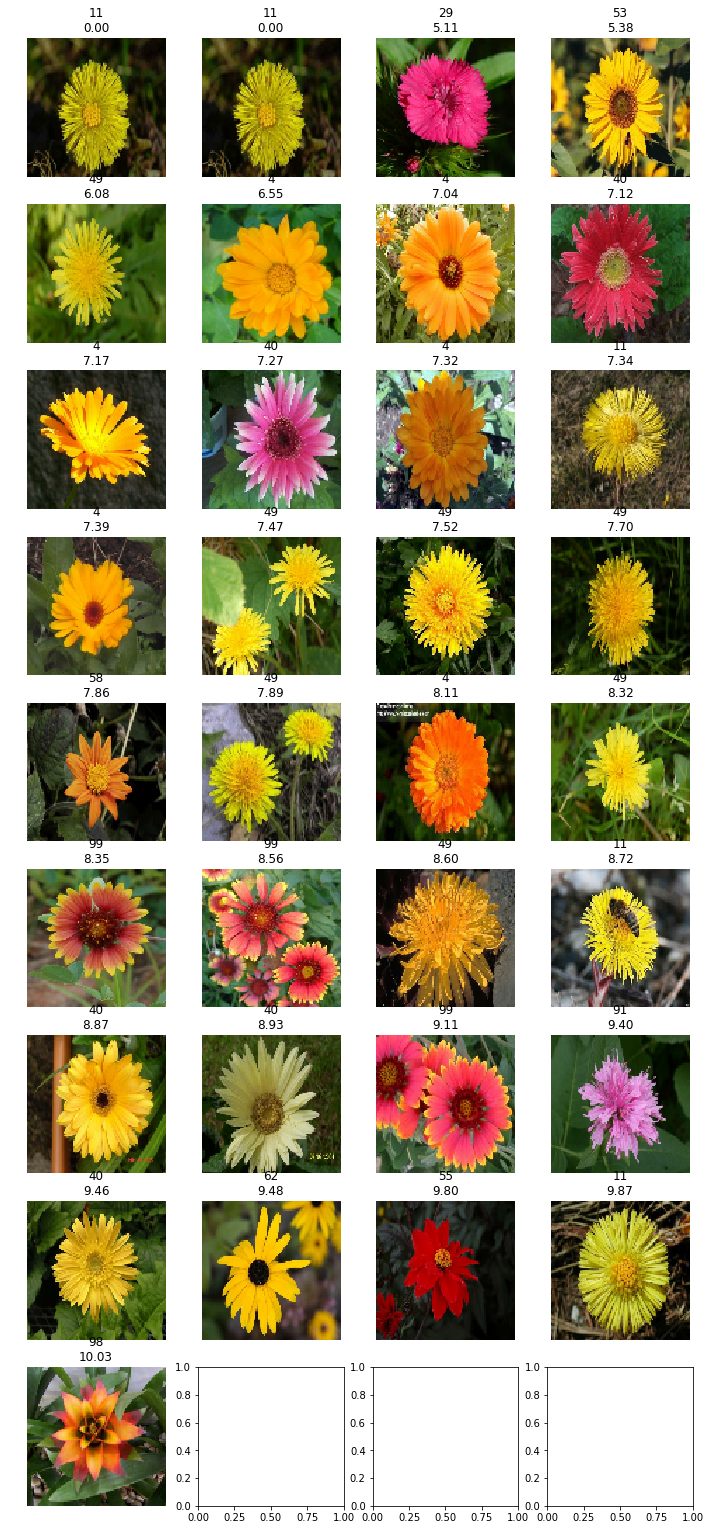

In [114]:
show_distances(
    inverse_preprocess_input(xs),
    ys,
    new_image_index,
    indices[0].tolist(),
    distances[0].tolist(),
)

##7. Building an inverse image search using Triplet Loss

In [0]:
learner.loss = tfa.losses.TripletSemiHardLoss()

In [0]:
# ;earner.stl_squeeze_layer = keras.layers.Dense(16, activation=None) # just input instead of keras.layers.Dense...

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(
        keras.layers.Dense(16, activation=None)(learner.concat_layer)
    ),
)

the other way to do the same - autoencoder is unsupervised learning model

In [118]:
learner.model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
learner.compile(optimizer=tf.keras.optimizers.Adam, lr=1e-4)

In [120]:
history = learner.model.fit(
    x=train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data_steps,
    validation_steps=validation_data_steps,
    epochs=3,
)

Train for 32 steps, validate for 32 steps
Epoch 1/3
32/32 [==============================] - 23s 733ms/step - loss: 0.8290 - val_loss: 0.8814
Epoch 2/3
32/32 [==============================] - 12s 366ms/step - loss: 0.7697 - val_loss: 0.8711
Epoch 3/3
32/32 [==============================] - 12s 367ms/step - loss: 0.7288 - val_loss: 0.8438


In [131]:
history = learner.model.fit(
    x=train_data,
    validation_data=validation_data,
    steps_per_epoch=validation_data_steps,
    validation_steps=validation_data_steps,
    epochs=10,
)

Train for 32 steps, validate for 32 steps
Epoch 1/10
32/32 [==============================] - 14s 428ms/step - loss: 0.6376 - val_loss: 0.8432
Epoch 2/10
32/32 [==============================] - 12s 368ms/step - loss: 0.6426 - val_loss: 0.8358
Epoch 3/10
32/32 [==============================] - 12s 366ms/step - loss: 0.5978 - val_loss: 0.8218
Epoch 4/10
32/32 [==============================] - 12s 364ms/step - loss: 0.5674 - val_loss: 0.8196
Epoch 5/10
32/32 [==============================] - 12s 369ms/step - loss: 0.5578 - val_loss: 0.8102
Epoch 6/10
32/32 [==============================] - 12s 366ms/step - loss: 0.5308 - val_loss: 0.7955
Epoch 7/10
32/32 [==============================] - 12s 365ms/step - loss: 0.4452 - val_loss: 0.8038
Epoch 8/10
32/32 [==============================] - 12s 362ms/step - loss: nan - val_loss: 1.0000
Epoch 9/10
32/32 [==============================] - 11s 348ms/step - loss: nan - val_loss: 1.0000
Epoch 10/10
32/32 [==============================] - 11

In [0]:
image_embeddings = learner.model.predict(xs)

In [123]:
image_embeddings.shape

(1024, 16)

In [0]:
nbrs = sk.neighbors.NearestNeighbors(n_neighbors=32, algorithm="ball_tree").fit(
    image_embeddings
)

In [125]:
new_image_index = np.random.randint(len(ys))
new_image_index

738

In [0]:
new_prepared_image = xs[new_image_index : new_image_index + 1]

In [0]:
new_image_embeddings = learner.model.predict(new_prepared_image)

In [0]:
distances, indices = nbrs.kneighbors(new_image_embeddings)

In [129]:
distances[0].tolist(), indices[0].tolist()

([3.313637344326714e-07,
  0.5242894454320687,
  0.538985325663501,
  0.5486390203293552,
  0.5910995769497162,
  0.6220044520344183,
  0.6388047871755995,
  0.6407216338137599,
  0.6481616030599558,
  0.6601537855189332,
  0.6682246036830262,
  0.6724678076507326,
  0.696107660410087,
  0.7073027683885682,
  0.7173037733678749,
  0.7191375858973561,
  0.7230136970145495,
  0.7239581640713181,
  0.7241774526353822,
  0.727538120030889,
  0.7275589865976263,
  0.7296425723272949,
  0.7347226242191777,
  0.7349973504263824,
  0.7364981480451475,
  0.7381717142912843,
  0.742697855870136,
  0.7443764086164495,
  0.7579921082900377,
  0.7589906789248357,
  0.76222818472534,
  0.7633643356867932],
 [738,
  667,
  277,
  279,
  632,
  818,
  742,
  111,
  514,
  940,
  10,
  848,
  13,
  190,
  662,
  564,
  618,
  460,
  841,
  527,
  812,
  368,
  557,
  105,
  829,
  590,
  178,
  823,
  334,
  761,
  351,
  795])

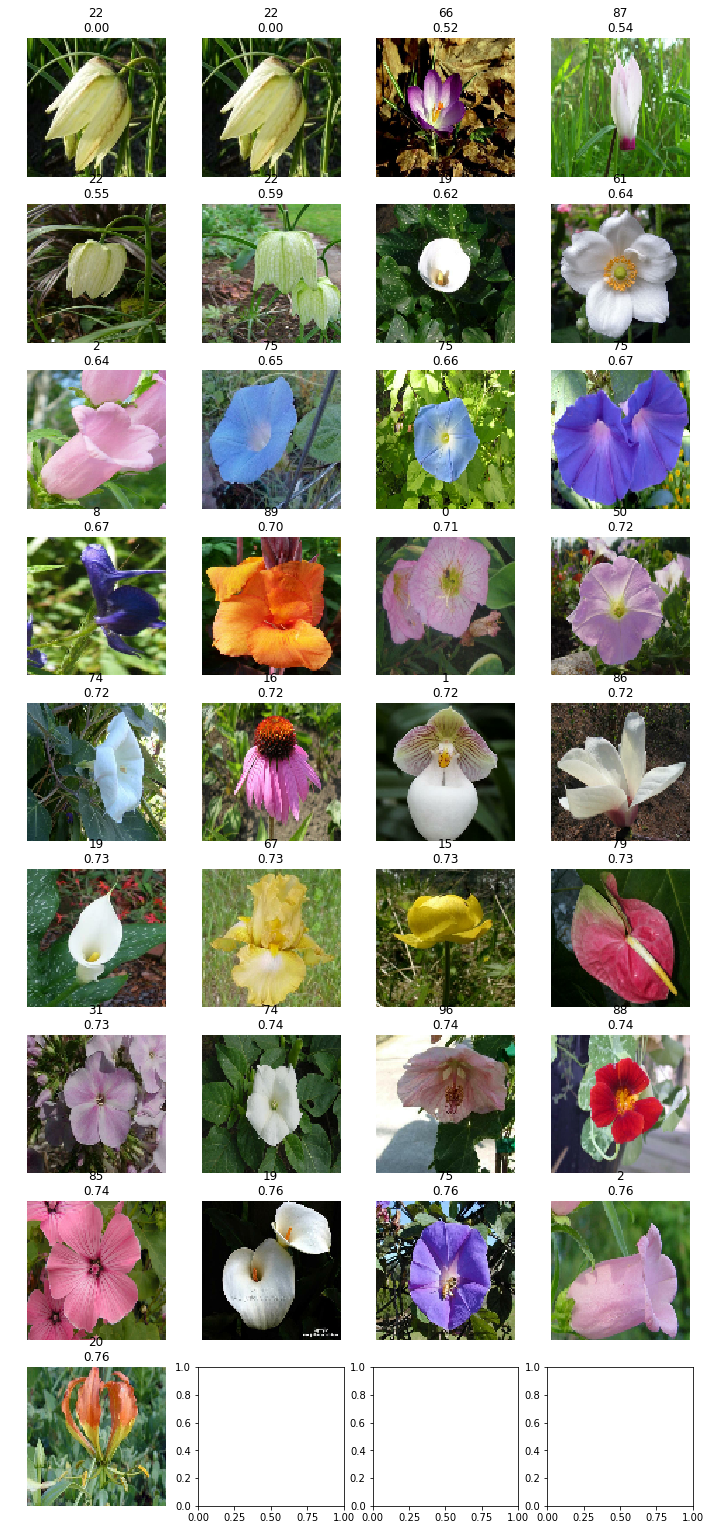

In [130]:
show_distances(
    inverse_preprocess_input(xs),
    ys,
    new_image_index,
    indices[0].tolist(),
    distances[0].tolist(),
)

**Summary**
The results with triple loss is 3 times better than without, as the distances between the closest classes are 3 times shorter, so all classes with more in common are combined in clusters that could be benefitial to work with this info later